In [94]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [102]:
def get_crossValidation_datasets(K, dataset):
    classes = dataset.target.unique()
    k_folds = []
    for cls in classes:
        df_cls = dataset[dataset.target == cls]
        np.random.seed(42)
        k_folds.append(np.array_split(df_cls.reindex(np.random.permutation(df_cls.index)), K))
    X_train = []
    X_test = []
    for k in range(K):
        train = []
        test = []
        for fold in k_folds:
            b = [x for i,x in enumerate(fold) if i != k]
            c = [x for i,x in enumerate(fold) if i == k]
            train.append(pd.concat(b))
            test.append(pd.concat(c))
        X_train.append(pd.concat(train))
        X_test.append(pd.concat(test))
    return X_train, X_test

In [95]:
def load_data(path):
    if 'parkinsons' in path:
        df = pd.read_csv(path)
        df.rename(columns={"Diagnosis":"target"}, inplace=True)
        df = (df-df.min())/(df.max()-df.min())
        df.fillna(0, inplace=True)
        return df
    
    if 'titanic' in path:
        df = pd.read_csv(path)
        df.rename(columns={"Survived": "target"}, inplace = True)
        del df["Name"]
        for col in df.columns:
            n = df.columns.nunique()
            if n < (len(df)/2):
                df[col] = df[col].astype('category').cat.codes
        df = (df - df.min())/(df.max() - df.min())
        df.fillna(0, inplace=True)
        return df        
    
    if 'loan' in path:
        df = pd.read_csv(path)
        df.rename(columns={"Loan_Status": "target"}, inplace = True)
        del df["Loan_ID"]
        for col in df.columns:
            n = df.columns.nunique()
            if n < (len(df)/2):
                df[col] = df[col].astype('category').cat.codes
        df = (df - df.min())/(df.max() - df.min())
        df.fillna(0, inplace=True)
        return df
    
    # Handwritten digits dataset!!!!!!!
    digits = datasets.load_digits()

    n_samples = len(digits.images)
    data = digits.images.reshape((n_samples, -1))
    labels = digits.target
    cols = digits.feature_names

    data_df = pd.DataFrame(data, columns = cols)
    labels_df = pd.DataFrame(labels, columns = ['target'])
    dataset = pd.concat([data_df, labels_df], axis = 1)
    dataset[cols] = (dataset[cols] - dataset[cols].min())/(dataset[cols].max() - dataset[cols].min())
    dataset.fillna(0, inplace=True)

    return dataset

In [10]:
# - k-NN algorithm : computing the distance matrix, and predicting the labels using (k)
# - returns the accuracy of the prediction

def predict(X_train, X_test, y_train, y_test, k):
  distance_matrix = cdist(X_train, X_test, metric='euclidean')
  distance_df = pd.DataFrame(distance_matrix).set_index(X_train.index)
  distance_df.columns = X_test.index

  predicted = []
  targets = []
  for x in distance_df.columns:
    predicted_label = y_train.loc[distance_df[x].nsmallest(k).index,:]['target'].value_counts().idxmax()
    predicted.append(predicted_label)
    targets.append(y_test.loc[x]['target'])
    
  return predicted, targets

In [66]:
# This function computes the prediction for different values of k (odd from 1 to 51)
def run_experiment(label, path):
    df = load_data(path)
    X_train, X_test = get_crossValidation_datasets(10, df)
    accs = []
    f1s = []
    for i in range(26):
        k = 2*i+1
        acc = []
        f1 = []
        for K in range(10):
            cols = list(X_train[K].columns)
            cols.remove('target')
            
            xtrain = X_train[K][cols]
            ytrain = X_train[K][['target']]
            xtest = X_test[K][cols]
            ytest = X_test[K][['target']]
                
            p, t = predict(xtrain, xtest, ytrain, ytest, k)
            predicted_df = pd.DataFrame(p, columns=['majority'])
            true_df = pd.DataFrame(t, columns=['target'])
            x = pd.concat([predicted_df, true_df], axis = 1)

            total = len(x)
            n = x.target.nunique()
            a = 0
            f = 0
            for c in x.target.unique():
                tp = len(x[(x.target == x.majority) & (x.target == c)])
                tn = len(x[(x.target != c) & (x.majority != c)])
                fn = len(x[(x.target == c) & (x.majority != x.target)])
                fp = len(x[(x.majority == c) & (x.majority != x.target)])
                a += ((tp+tn)/total)
                f += ((2*tp)/(2*tp+fn+fp))
            a = a/n
            f = f/n
            acc.append(a)
            f1.append(f)
        accs.append(sum(acc)/10)
        f1s.append(sum(f1)/10)
    return accs, f1s

In [103]:
accs_digits, f1s_digits = run_experiment('test', './')

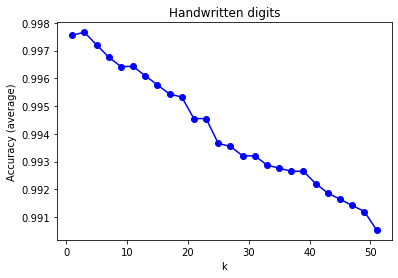

In [104]:
plt.plot([(2*i+1) for i in range(26)], accs_digits, '-bo')
plt.xlabel('k')
plt.ylabel('Accuracy (average)')
plt.title('Handwritten digits')
plt.show()

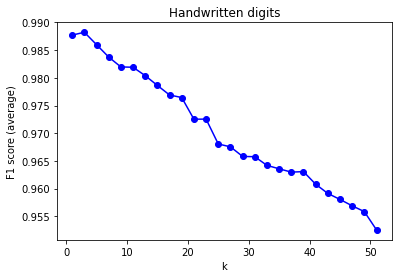

In [105]:
plt.plot([(2*i+1) for i in range(26)], f1s_digits, '-bo')
plt.xlabel('k')
plt.ylabel('F1 score (average)')
plt.title('Handwritten digits')
plt.show()

In [106]:
accs_digits[1], f1s_digits[1]

(0.9976576133209296, 0.9882397196839922)

In [77]:
accs, f1s = run_experiment('test', './data/parkinsons.csv')

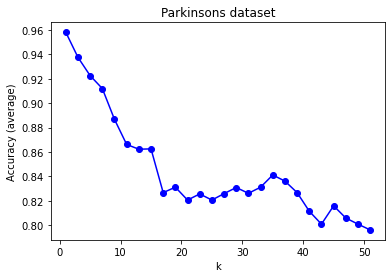

In [78]:
plt.plot([(2*i+1) for i in range(26)], accs, '-bo')
plt.xlabel('k')
plt.ylabel('Accuracy (average)')
plt.title('Parkinsons dataset')
plt.show()

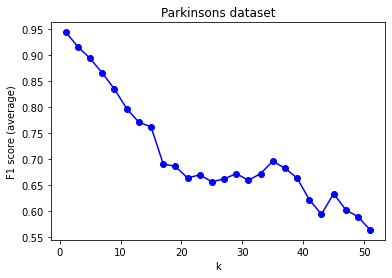

In [79]:
plt.plot([(2*i+1) for i in range(26)], f1s, '-bo')
plt.xlabel('k')
plt.ylabel('F1 score (average)')
plt.title('Parkinsons dataset')
plt.show()

In [82]:
accs[0], f1s[0]

(0.9580701754385965, 0.9441181600914638)

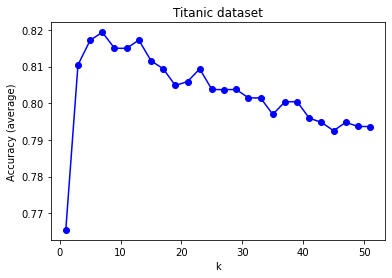

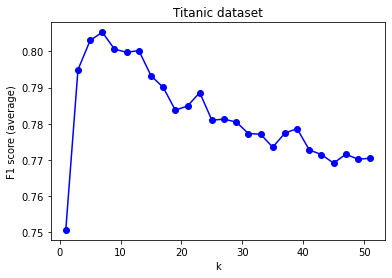

In [88]:
accs, f1s = run_experiment('test', './data/titanic.csv')

plt.plot([(2*i+1) for i in range(26)], accs, '-bo')
plt.xlabel('k')
plt.ylabel('Accuracy (average)')
plt.title('Titanic dataset')
plt.show()

plt.plot([(2*i+1) for i in range(26)], f1s, '-bo')
plt.xlabel('k')
plt.ylabel('F1 score (average)')
plt.title('Titanic dataset')
plt.show()

In [92]:
accs[3], f1s[3]

(0.8193984791737601, 0.8053218646835699)

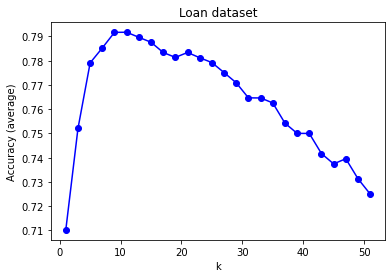

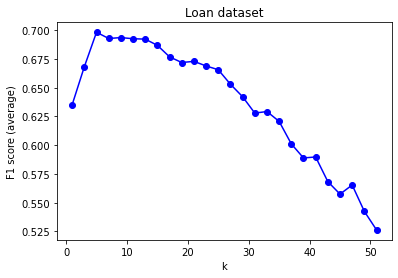

In [97]:
accs, f1s = run_experiment('test', './data/loan.csv')

plt.plot([(2*i+1) for i in range(26)], accs, '-bo')
plt.xlabel('k')
plt.ylabel('Accuracy (average)')
plt.title('Loan dataset')
plt.show()

plt.plot([(2*i+1) for i in range(26)], f1s, '-bo')
plt.xlabel('k')
plt.ylabel('F1 score (average)')
plt.title('Loan dataset')
plt.show()

k = 11 has highest accuracy

k = 5 has highest f1 score

(k = 9,11 almost same values)

In [99]:
accs[4], f1s[4]

(0.7916748082211608, 0.6936333352308583)

In [100]:
accs[2], f1s[2]

(0.7790861557388913, 0.6982747219423813)

In [101]:
accs[5], f1s[5]

(0.7917173252279635, 0.6926332768097474)